In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [ ]:
# Read in the dataset and since this is a time series dataset, we need to parse
# dates as well
df = pd.read_csv('Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [ ]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [ ]:
# Just changing the column name to Production since the original
# name is kind of weird or maybe some kind of code (who knows).
df.columns = ['Production']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [ ]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


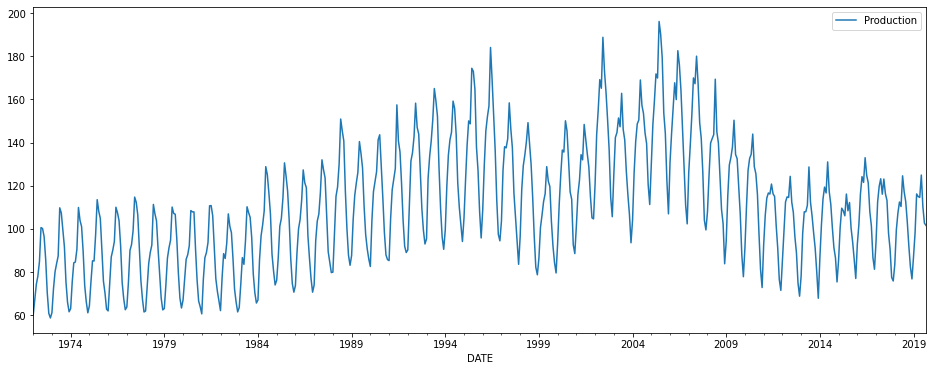

In [ ]:
# Let's check out the plot, from the plot we can clearly see that
# there is some kind of seasonality here
df.plot(figsize=(16, 6))

In [ ]:
len(df)

573

In [ ]:
index = len(df) - 24

In [ ]:
# The training data is everything before the index
train = df.iloc[:index]

In [ ]:
# The testing data is everything after the index.
test = df.iloc[index:]

In [ ]:
len(test)

24

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Need to scale our test data in order to make sure that every
# data point is of same scale without any fluctuations
scaled_train = scaler.fit_transform(train)

In [ ]:
# Same for the test set
scaled_test = scaler.transform(test)

In [ ]:
# In order to make sure that our model learns something,
# we need to pick a number that captures the seasonality
# We can take 12 where the number represents months but
# we have taken 18 just in case.
length = 18

In [ ]:
# Create a time series generator from the scaled train and test
# data, the batch size should be kept reasonable
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    scaled_train,
    scaled_train,
    length = length,
    batch_size = 1
)

In [ ]:
# We only have production here
n_features = 1

In [ ]:
# Create our Recurrent Neural Network with one LSTM layer having 100 neurons
# and the input shape is (18, 1)

model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(tf.keras.layers.Dense(1))

# Use mean squared error and adam as our optimizer
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
# Around 40 thousand parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
validation_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    scaled_test,
    scaled_test,
    length = length,
    batch_size = 1
)

In [ ]:
# We need to use early stop callback so that
# we can stop training as soon as our loss curve
# or validation loss curve starts to go up or in other
# words our model starts to overfit.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 2
)

In [ ]:
# Fit the model on data and choose 100 epochs. Technically, we
# can choose as many epochs as we want since the early stop callback
# will stop it as soon as our model starts to overfit
model.fit(generator, epochs = 100, validation_data=validation_generator, callbacks = [early_stop])

Epoch 1/100
531/531 [==============================] - 11s 16ms/step - loss: 0.0265 - val_loss: 0.0020
Epoch 2/100
531/531 [==============================] - 8s 15ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 3/100
531/531 [==============================] - 8s 15ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 4/100
531/531 [==============================] - 8s 14ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 5/100
531/531 [==============================] - 8s 15ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 6/100
531/531 [==============================] - 8s 14ms/step - loss: 0.0031 - val_loss: 0.0034


In [ ]:
# Get the loss curves and convert them to a pandas dataframe
losses = pd.DataFrame(model.history.history)

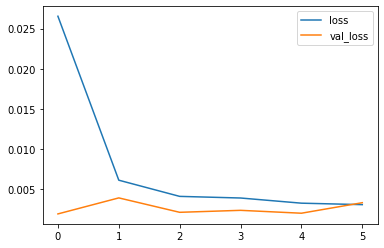

In [ ]:
# We can see that our validation loss curve was starting
# to go higher but thanks to early stopping, the model
# stopped training
losses.plot()

In [ ]:
# Get the predictions
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], 
                            [[current_pred]],
                            axis = 1)

In [ ]:
# Need to inverse our transformation on the test set
# because the scale is different
true_preds = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Not very close but something is better than nothing
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,96.330013
2017-11-01,77.4378,91.487421
2017-12-01,75.8118,92.666782
2018-01-01,83.4343,101.350374
2018-02-01,99.4899,112.278801
2018-03-01,107.3152,120.549938
2018-04-01,112.4309,126.192632
2018-05-01,110.3544,129.205457
2018-06-01,124.5841,129.658599


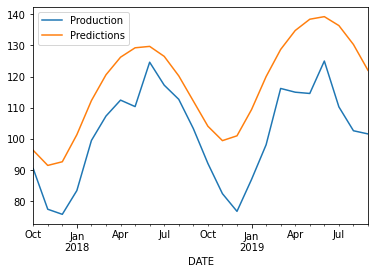

In [ ]:
# Not a state of the art model but it is
# atleast trying to pickup the seasonality pattern
test.plot()

In [ ]:
from sklearn import metrics

In [ ]:
print(np.sqrt(metrics.mean_squared_error(test['Production'], test['Predictions'])))

17.24887023798812
